In [1]:
import os
#import scipy
import numpy as np
import pandas as pd
#import netCDF4 as nc
import matplotlib.pyplot as plt
import sys
#import skimage
from functools import reduce


#from sklearn.cross_decomposition import PLSRegression, PLSCanonical, CCA
#from sklearn.decomposition import PCA

#from sklearn.cluster import FeatureAgglomeration
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import cross_validate, RepeatedKFold


sys.path.append('../functions/')
from functions import load_lat_lon_area, display_map, reverse_mask, nanaverage, nanstd, display_number_of_runs

from OC_methods import performances_methods

In [2]:
from import_data import import_CMIP6_TOS_SOS, import_CMIP6_AMOC, select_common_members, import_AMOC_obs, import_TOS_SOS_obs, region_average_TOS_SOS_obs, display_regions
from format_data import create_X_AMOC_feature, create_X_TOS_SOS_features, create_Y_AMOC_feature, average_member_perModel


def construct_data_given_scenario(scenario,
                                 X_choice, anomalie_Y, min_Y, max_Y,
                                  min_Y_ref, max_Y_ref, min_X, max_X,
                                  include_AMOC_in_predictors):
    #================================================ Import data
    #---- Import labels longitudes and latitudes
    latitudes, longitudes, area_perLat_per_Lon = load_lat_lon_area("../data/area_r360x180.nc")
    longitudes[longitudes>180] -= 360

    #---- Import CMIP6 TOS and SOS
    years_to_select = np.arange(1850, 2100+1)
    [X_simu_perSample_perYear_perFeature_bis, name_samples_X, nb_var, list_name_per_var
                ] = import_CMIP6_TOS_SOS(scenario, years_to_select)

    #---- Import CMIP6 AMOC
    [hist_times, hist_name_samples, hist_AMOC, ssp_times, ssp245_name_samples, ssp245_AMOC
            ] = import_CMIP6_AMOC(scenario)

    #---- Select only the members that are available for both TOS, SOS and AMOC
    [X_simu_perSample_perYear_perFeature, Y, times_Y, final_name_samples
            ] = select_common_members(name_samples_X, hist_name_samples, ssp245_name_samples,
                             X_simu_perSample_perYear_perFeature_bis,
                             years_to_select, hist_times, ssp_times,
                             hist_AMOC, ssp245_AMOC)

    #---- Import AMOC observations (RAPID)
    obs_AMOC_times, obs_AMOC_values = import_AMOC_obs(display=False)

    #---- Display the number of members given by each climate model
    final_name_models, final_weight_per_sample = display_number_of_runs(final_name_samples, display=False)
    
    #---- Import TOS and SOS observations
    [ObsData_perVar_perYear_perCell_, ObsVar_perVar_perYear_perCell_,
     obs_times, mask_perVar
            ] = import_TOS_SOS_obs(years_to_select, display=False)

    [X_obs_perYear_perFeature, X_obsVar_perYear_perFeature,
     name_perBox, list_idCell_perFeature, list_id_box_perFeature,
     list_id_var_perFeature, colors_perBox,
     middle_cell_perBox, list_name_perFeature, nb_box
            ] = region_average_TOS_SOS_obs(longitudes, latitudes, X_simu_perSample_perYear_perFeature,
                                   ObsData_perVar_perYear_perCell_, ObsVar_perVar_perYear_perCell_,
                                   area_perLat_per_Lon, list_name_per_var, obs_times, mask_perVar,
                                   final_weight_per_sample, years_to_select,
                                   display=False)
    
    #================================================ Construct X and Y
    #------- X definition for the AMOC
    [name_X_AMOC, X_simu_AMOC, X_obs_AMOC, X_AMOC_mean_1850_1900
            ] = create_X_AMOC_feature(X_choice, Y, times_Y, obs_AMOC_values, obs_AMOC_times)
    #print("{} (RAPID) is {:.2f} Sv.".format(name_X_AMOC, X_obs_AMOC))

    #------- X definition for the TOS and SOS
    X_obs, X_simu = create_X_TOS_SOS_features(X_choice, min_X, max_X, 
                                              X_obs_perYear_perFeature, obs_times,
                                              X_simu_perSample_perYear_perFeature, years_to_select)

    #------- Y definition for the AMOC
    Y_simu, name_Y, Y_ref = create_Y_AMOC_feature(anomalie_Y, min_Y, max_Y,
                              min_Y_ref, max_Y_ref,
                              Y, years_to_select)

    #------- Select only the run without nan values
    model_to_keep     = np.logical_not(np.isnan(Y_simu))
    Y_ref             = Y_ref[model_to_keep]
    Y_simu            = Y_simu[model_to_keep]
    X_simu            = X_simu[model_to_keep]
    X_simu_AMOC       = X_simu_AMOC[model_to_keep]
    final_name_samples = final_name_samples[model_to_keep]
    final_name_models  = np.array(final_name_models)[model_to_keep]
    X_AMOC_mean_1850_1900   = X_AMOC_mean_1850_1900[model_to_keep]

    #------- Combine (or not) the X SST and SSS features with the X AMOC feature
    if include_AMOC_in_predictors:
        X_simu = np.concatenate((X_simu, X_simu_AMOC.reshape(-1,1)), axis=1)
        X_obs  = np.concatenate((X_obs, X_obs_AMOC.reshape(-1)))
        list_name_perFeature.append(name_X_AMOC)
        list_id_var_perFeature.append(2)

    #------- Average each model on its available members
    [uniques_models, Y_simu_resampled, Y_ref_resampled, X_simu_resampled, X_simu_AMOC_resampled, X_AMOC_mean_1850_1900_resampled
            ] = average_member_perModel(final_name_models, X_simu, Y_simu,
                                Y_ref, X_simu_AMOC, X_AMOC_mean_1850_1900)
    nb_models = len(uniques_models)

    #------- Replacement
    X_simu                = X_simu_resampled
    Y_simu                = Y_simu_resampled
    Y_ref                 = Y_ref_resampled
    X_simu_AMOC           = X_simu_AMOC_resampled
    X_AMOC_mean_1850_1900 = X_AMOC_mean_1850_1900_resampled
    final_name_models     = np.copy(uniques_models)

    return [X_simu, Y_simu, Y_ref, X_simu_AMOC,
            X_AMOC_mean_1850_1900, final_name_models,
            X_obs, X_obs_AMOC, name_X_AMOC, name_Y]




# Parameters

In [3]:
#------- Y
anomalie_Y = False
min_Y      = 2091
max_Y      = 2100
min_Y_ref  = 1850
max_Y_ref  = 1900

#------- X
X_choice = "mean" # mean, trend
min_X    = 1900 # 1900 or 1975 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
max_X    = 2020

#------- X en multivarié : est ce qu'on inclue l'AMOC passé en plus des 18 features ?
include_AMOC_in_predictors=True

# Performances comparison for different scenarios

In [4]:
X_simu_perScenario = []
Y_simu_perScenario = []
models_perScenario = []
poids_wA_perScenario = []
X_simu_AMOC_perScenario = []
list_list_LOO_perScenario = []
list_list_predictions_perScenario = []
list_list_std_without_perScenario = []

list_scenarios = ["ssp126", "ssp245", "ssp585"]
for scenario in list_scenarios:
    #----------- Construct data for different scenarios
    [X_simu, Y_simu, Y_ref, X_simu_AMOC, X_AMOC_mean_1850_1900, final_name_models,
     X_obs, X_obs_AMOC, name_X_AMOC, name_Y
        ] = construct_data_given_scenario(scenario,
                                     X_choice, anomalie_Y, min_Y, max_Y,
                                      min_Y_ref, max_Y_ref, min_X, max_X,
                                      include_AMOC_in_predictors)
    
    #----------- Store the data
    X_simu_AMOC_perScenario.append(X_simu_AMOC)
    X_simu_perScenario.append(X_simu)
    Y_simu_perScenario.append(Y_simu)
    models_perScenario.append(final_name_models)
    
    
    #----------- Compute performances
    [name_methods, list_list_predictions, list_list_std_without, list_list_LOO, poids_wA
            ] = performances_methods(X_simu_AMOC, X_obs_AMOC, X_simu, X_obs, Y_simu)
    
    poids_wA_perScenario.append(poids_wA)
    list_list_LOO_perScenario.append(list_list_LOO)
    list_list_predictions_perScenario.append(list_list_predictions)
    list_list_std_without_perScenario.append(list_list_std_without)


C:\Users\vportmann\.conda\envs\test\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vportmann\.conda\envs\test\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


MMM

wAverage

LR

Ridge

RF

MMM

wAverage

LR

Ridge

RF



C:\Users\vportmann\.conda\envs\test\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vportmann\.conda\envs\test\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\vportmann\Desktop\ComparisonAmocConstraints\notebooks\../functions\format_data.py:99: RuntimeWarning: Mean of empty slice
  Y_simu_anom = np.nanmean(Y_anom[:, times_to_mean], axis=1)
C:\Users\vportmann\Desktop\ComparisonAmocConstraints\notebooks\../functions\format_data.py:106: RuntimeWarning: Mean of empty slice
  Y_simu = np.nanmean(Y[:, times_to_mean], axis=1)


MMM

wAverage

LR

Ridge

RF

MMM

wAverage

LR

Ridge

RF



C:\Users\vportmann\.conda\envs\test\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vportmann\.conda\envs\test\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


MMM

wAverage

LR

Ridge

RF

MMM

wAverage

LR

Ridge

RF



In [75]:
def cross_validation_plot(ax):
    # Display parameters
    x = 0.1*1.8
    alpha = 0.6
    beta = x
    xmin = 0
    for id_method in range(nb_methods):
        for i in range(2):
            if id_method==0: shift = 0
            else: shift = beta*(2*i-1)
            LOO_err = list_list_LOO_perScenario[id_scenario][i][id_method]

            if i==0:
                linestyle="solid"
                ax.fill_between(id_method+shift+np.array([-x,x]), y1=[xmin,xmin], y2=LOO_err*np.array([1,1]), color=colors[id_method], alpha=alpha)
            else:
                linestyle="dashed"
                ax.fill_between(id_method+shift+np.array([-x,x]), y1=[xmin,xmin], y2=LOO_err*np.array([1,1]),
                                     color="none", hatch="XXX", edgecolor=colors[id_method])
            #if id_method==3 and i==1:
            #    ax.fill_between(id_method+shift+np.array([-x,x]), y1=xmin*np.ones(2), y2=(LOO_err)*np.ones(2),
            #                     facecolors='none', edgecolors='black', linewidth=1)


            #axes[1].fill_between(id_method+shift+np.array([-x,x]), y1=[xmin,xmin], y2=LOO*np.array([1,1]), color=colors[id_method])

    if (id_scenario==nb_scenarios-1):
        ax.set_xticks(range(nb_methods))
        ax.set_xticklabels(name_methods, fontsize=20, rotation=60, ha='right', va='top')
        ax.get_xticklabels()[3].set_fontweight("bold")
    else:
        ax.set_xticks([])
    ax.grid(axis="y")
    plt.rc('axes', axisbelow=True)
    #axes[0].legend(title="Constrained by")
    line1 = ax.fill_between(id_method+np.array([-x,x])+10, y1=[xmin,xmin], y2=LOO_err*np.array([1,1]),
                                 color="gray", alpha=alpha, label="one predictor")
    line2 = ax.fill_between(id_method+np.array([-x,x])+10, y1=[xmin,xmin], y2=LOO_err*np.array([1,1]),
                                 color="none", hatch="XXX", edgecolor="gray", label="multiple predictor")
    leg = fig.legend([line1, line2],
               ["one observed variable", "multiple observed variables"], #"1 "+r"$\sigma$"+" interval"],
               title="Constrained by", loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=20)
    plt.rcParams['legend.title_fontsize'] = 20
    leg._legend_box.align = "left"
    
    ax.set_ylim(0, max_*1.05)
    ax.set_xlim(-0.5, nb_methods-0.5)
    ax.tick_params(labelsize=20) 

corr=0.86
corr=0.84
corr=0.78


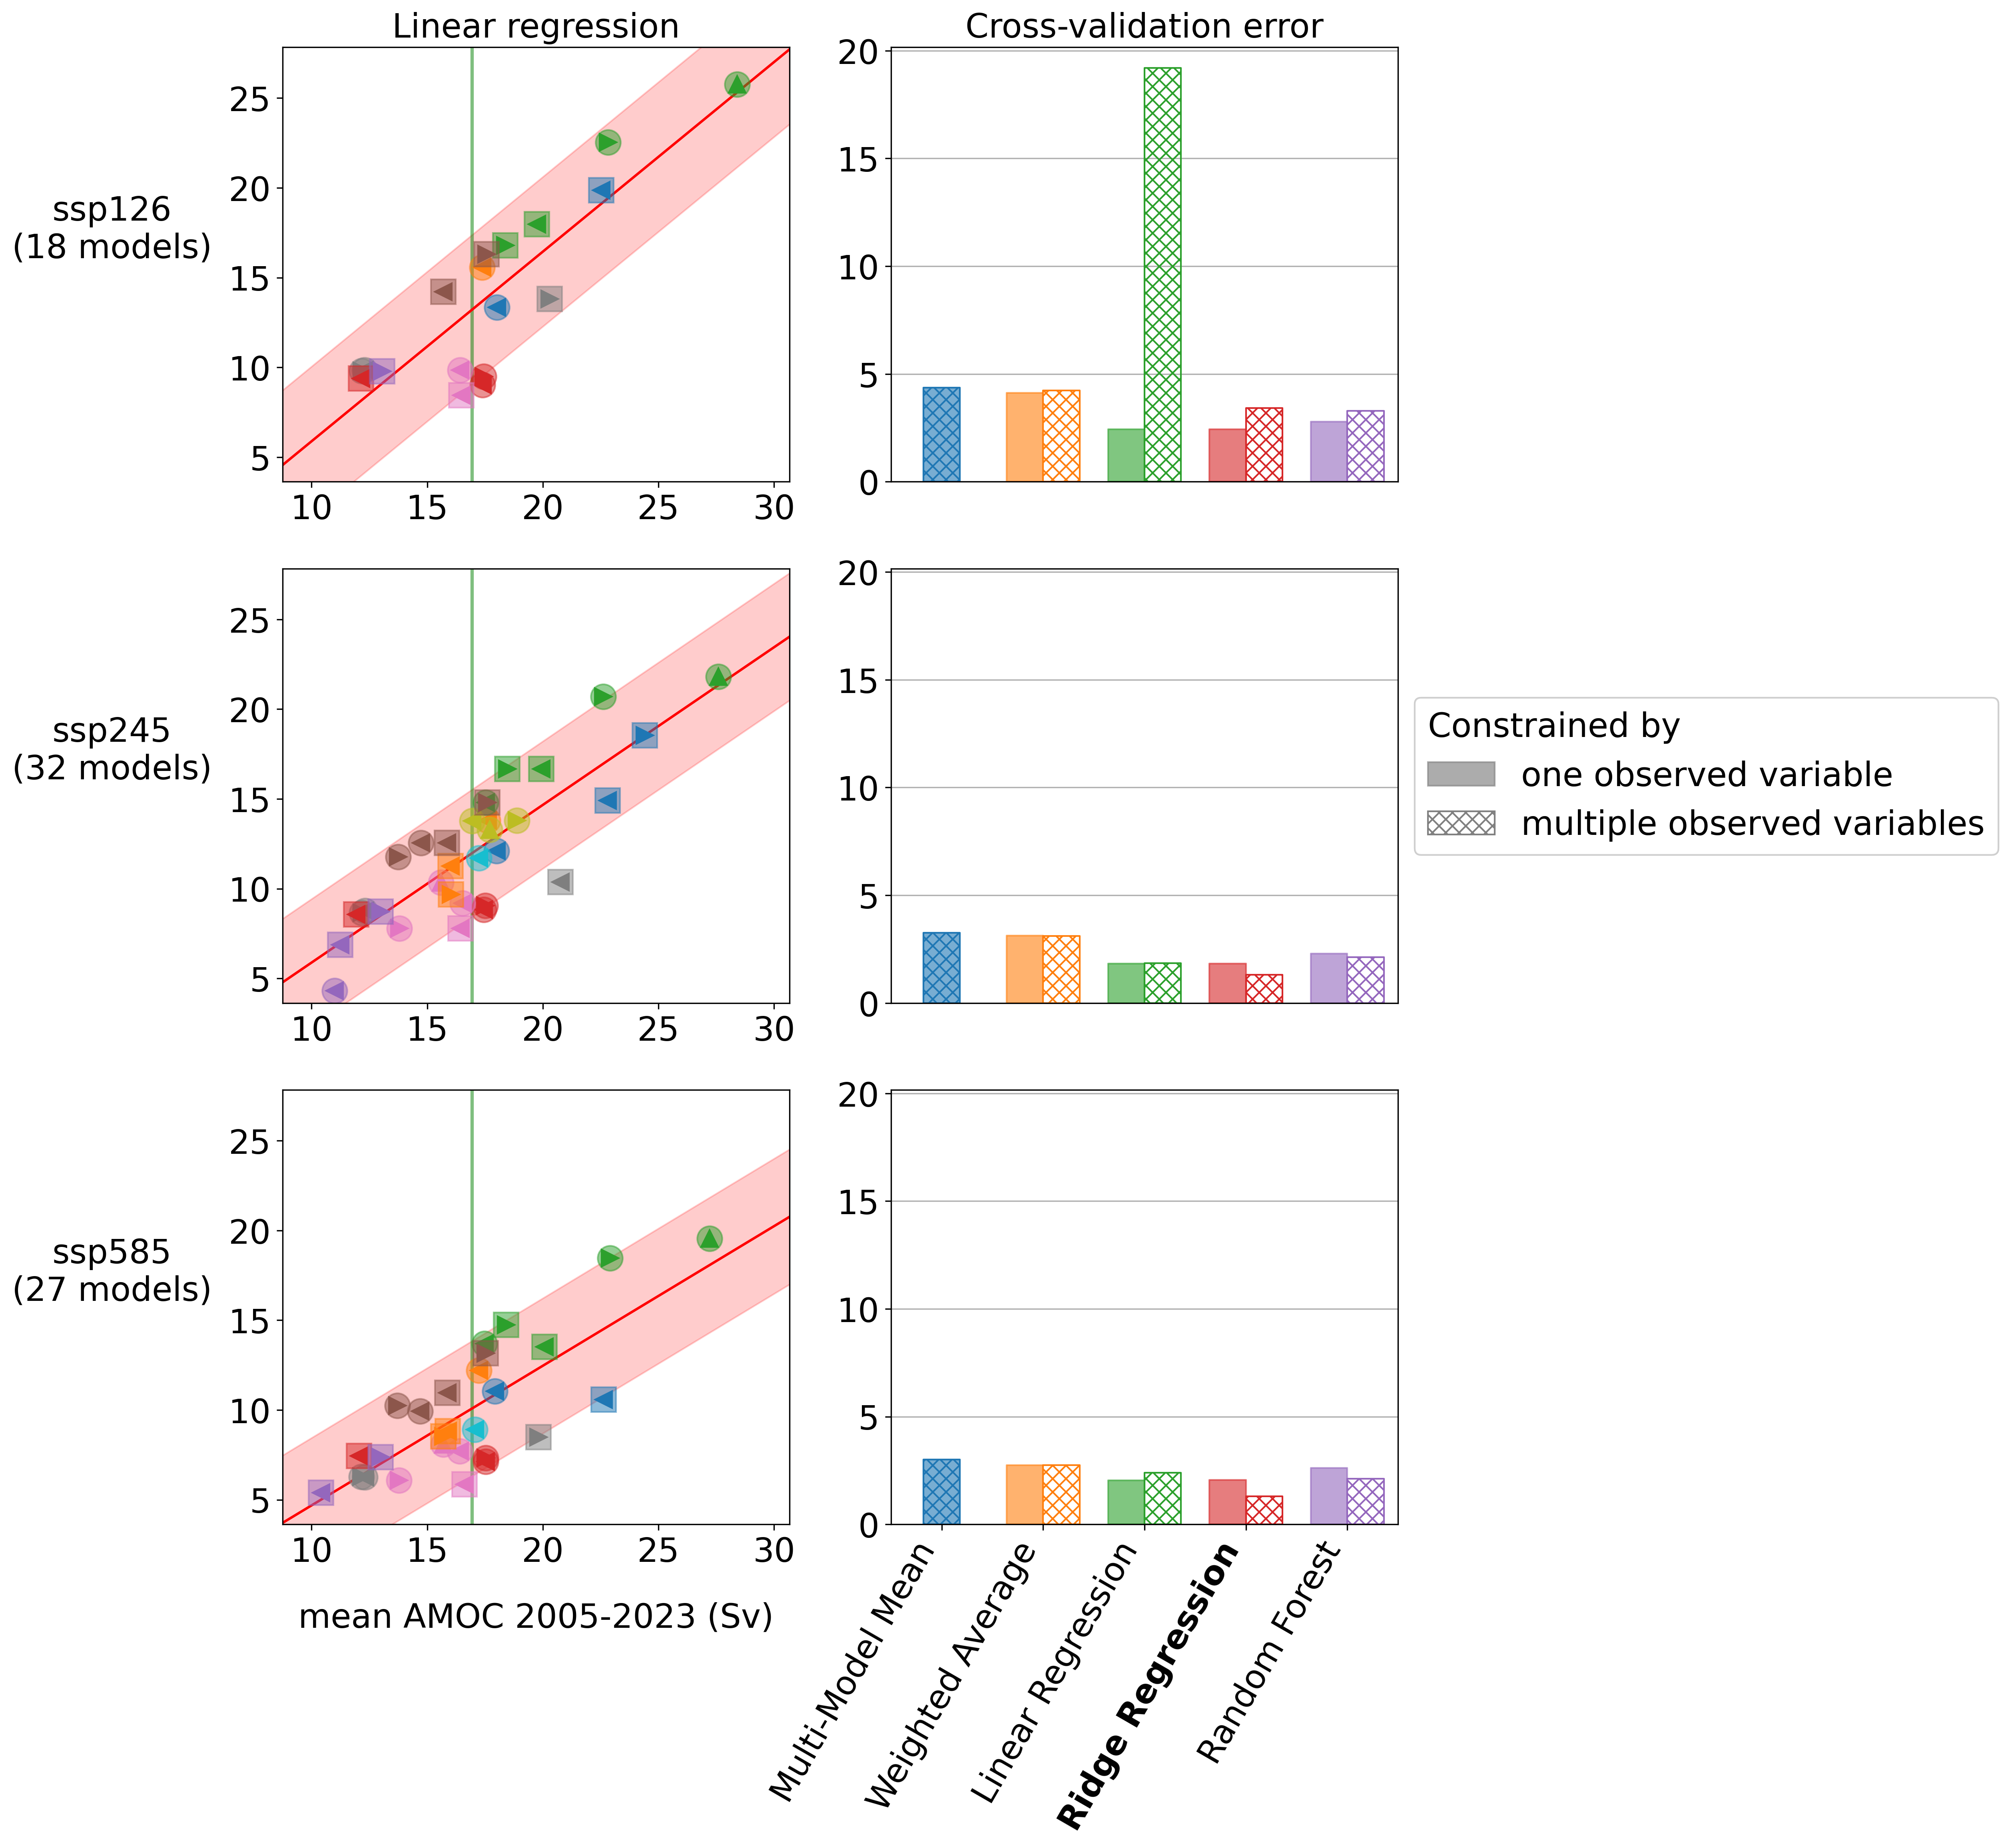

In [86]:
from scipy.stats import t
from sklearn.linear_model import LinearRegression
from display_results import define_color_and_marker
name_methods = ["Multi-Model Mean", "Weighted Average", "Linear Regression", "Ridge Regression", "Random Forest"]


max_         = np.max(list_list_LOO_perScenario)
nb_scenarios = len(list_scenarios)
nb_methods   = len(list_list_LOO_perScenario[0][0])
fig, axes    = plt.subplots(nb_scenarios, 2, dpi=300, figsize=(2*6,2*8))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Climate models display
all_models   = np.unique(np.concatenate(models_perScenario))
list_front_markers = ["<", ">", "^", "v", "o", "s", "p", "*", "h", "H", "d", "P", "X"] #, "+", "x", "*", "o"
list_back_markers  = ["o", "s", "d"]
list_color, list_front_marker, list_back_marker = define_color_and_marker(all_models, list_front_markers, list_back_markers)

for id_scenario in range(nb_scenarios):
    name_scenario = list_scenarios[id_scenario]
    X_simu_AMOC = X_simu_AMOC_perScenario[id_scenario]
    X_simu = X_simu_perScenario[id_scenario]
    Y_simu = Y_simu_perScenario[id_scenario]
    name_models = models_perScenario[id_scenario]
    list_list_std_without = list_list_std_without_perScenario[id_scenario]
    list_list_predictions = list_list_predictions_perScenario[id_scenario]

    #------------ Display cross-validation errors
    cross_validation_plot(axes[id_scenario, 1])
    
    #------------ Display the linear regression example
    probability = 0.9
    ax = axes[id_scenario, 0]
    z = t.interval(probability, np.inf, loc=0, scale=1)[1]
    std_err_LR  = z*list_list_std_without[0][2]
    std_err_wA  = z*list_list_std_without[0][1]
    weights     = poids_wA[0]
    uni_lr_pred = list_list_predictions[0][2]
    uni_wA_pred = list_list_predictions[0][1]
    
    print("corr={:.2f}".format(np.corrcoef(X_simu_AMOC, Y_simu)[0,1]))

    # Display parameters
    alpha = 0.9
    xmargin = 0.5
    probability = 0.9
    markersize = 15
    xmin = np.min(np.concatenate(X_simu_AMOC_perScenario))
    xmax = np.max(np.concatenate(X_simu_AMOC_perScenario))
    ymin = np.min(np.concatenate(Y_simu_perScenario))
    ymax = np.max(np.concatenate(Y_simu_perScenario))
    
    lr        = LinearRegression().fit(X_simu_AMOC.reshape(-1, 1), Y_simu)
    ypred     = lr.predict(X_simu_AMOC.reshape(-1, 1))
    ypred_obs = lr.predict(X_obs_AMOC.reshape(-1, 1))[0]
    x         = np.linspace(xmin-10, xmax+10)
    y         = lr.predict(x.reshape(-1, 1))

    ax.axvline(X_obs_AMOC, color='green', alpha=0.5, label="real-world observation", linewidth=2)
    #line1 = plt.fill_betweenx([np.min(Y_simu), np.max(Y_simu)], X_obs_AMOC-X_obs_AMOC_std, X_obs_AMOC+X_obs_AMOC_std,
    #                  alpha=0., hatch=r"\\", label='observation $\pm \sigma$')
    line2 = ax.plot(x, lr.predict(x.reshape(-1, 1)), color='red')#, label='linear regression')
    ax.fill_between(x, y-std_err_LR, y+std_err_LR, color='red', alpha=0.2)

    #xmin, xmax = plt.gca().get_xlim()
    #plt.errorbar(xmin+xmargin, uni_lr_pred, yerr=std_err_LR, capsize=7, color="black", lw=2, alpha=0.8, fmt="_",
    #             label="{:.1f} ".format(uni_lr_pred)+r"$\pm$"+" {:.1f} Sv".format(std_err_LR)) # r"$\hat{f}(x_0)\pm \hat{\sigma}_{\varepsilon}$")

    #legend1 = plt.legend()
    #ax.hlines(y=uni_lr_pred, xmin=xmin+xmargin, xmax=X_obs_AMOC, linestyle="dotted", color='black', linewidth=1)
    #ax.hlines(y=uni_lr_pred-std_err_LR, xmin=xmin+xmargin, xmax=X_obs_AMOC, linestyle="dotted", color='black')
    #ax.hlines(y=uni_lr_pred+std_err_LR, xmin=xmin+xmargin, xmax=X_obs_AMOC, linestyle="dotted", color='black')


    #------------- Display the model
    _, id_models_plotted, _ = np.intersect1d(all_models, name_models, return_indices=True)
    list_color_, list_front_marker_, list_back_marker_ = np.array(list_color)[id_models_plotted], np.array(list_front_marker)[id_models_plotted], np.array(list_back_marker)[id_models_plotted]


    list_points = []
    for id_model in range(len(name_models)):
        front_marker = list_front_marker_[id_model]
        back_marker  = list_back_marker_[id_model]
        color        = list_color_[id_model]
        alpha        = 0.5
        a, = ax.plot(X_simu_AMOC[id_model], Y_simu[id_model], marker=back_marker, c=color, alpha=alpha, markersize=markersize, linewidth=0.)
        b, = ax.plot(X_simu_AMOC[id_model], Y_simu[id_model], marker=front_marker, label=name_models[id_model], c=color, alpha=1, linewidth=0., markersize=markersize/1.5)
        list_points.append((a,b))

    #fig.legend(list_points, final_name_models, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=6)

    #legend2 = plt.legend(list_points, final_name_models, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    ax.set_ylabel(name_Y+" (Sv)", fontsize=20)
    if (id_scenario==nb_scenarios-1):
        ax.set_xlabel(name_X_AMOC+" (Sv)", fontsize=20, labelpad=20)
    
    
    a = 0.08
    ax.set_xlim((1-2*a)*xmin, xmax*(1+a))
    ax.set_ylim((1-2*a)*ymin, ymax*(1+a))
    ax.tick_params(labelsize=20) 
    
for ax, col in zip(axes[0], ["Linear regression", "Cross-validation error"]):
    ax.set_title(col, fontsize=20)

i = 0
for ax, row in zip(axes[:,0], list_scenarios):
    ax.set_ylabel(row+"\n({} models)".format(len(X_simu_perScenario[i])), rotation=0, fontsize=20, labelpad=70)
    i += 1
    
plt.show()



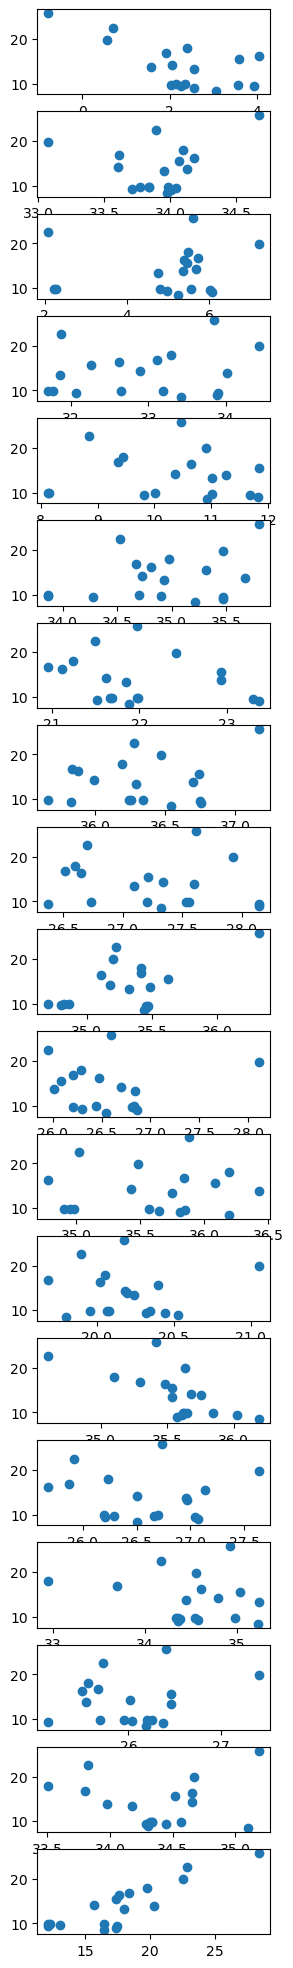

In [8]:
id_scenario = 0
X_simu_AMOC = X_simu_AMOC_perScenario[id_scenario]
X_simu = X_simu_perScenario[id_scenario]
Y_simu = Y_simu_perScenario[id_scenario]

nb_features = len(X_simu[0])
fig, axes = plt.subplots(nb_features, 1, figsize=(3,25))
for id_feature in range(nb_features):
    axes[id_feature].scatter(X_simu[:, id_feature], Y_simu)